In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import xgboost
import shap

In [86]:
# ONLY USE IF DATASET IS AVAILABLE
df_stats = pd.read_csv('dataset_new_clean.csv',sep=";")

# Read Data

In [ ]:
df = pd.read_pickle('../clean/inactive_list_cleaned.p')
df = df.reset_index()
df = df.drop(columns=['index'],axis=1)
df['Season']=pd.DatetimeIndex(df['Date']).year
df['Month']=pd.DatetimeIndex(df['Date']).month
df.head()

In [51]:
df_stats = pd.read_pickle('../clean/player_stats_cleaned.p')
df_stats = df_stats.reset_index()
df_stats = df_stats.drop(columns=['index'], axis=1)
df_stats['target'] = 0

def label_target():
    for i,r in df_stats.iterrows():
        on_il = np.sum(df[(df.Player==r.Player) & (df.Season == r.Year)]['on_IL'])
        df_stats.at[i,'target'] = int(on_il>0)

label_target()

In [ ]:
df_stats.head()

In [ ]:
df_stats.describe()

In [ ]:
df_stats_clean = df_stats.drop(columns=[
    'Player',
    'Season',
    'Team',
    'PLAYER_ID',
    'Year'],axis=1)
df_stats_clean = df_stats_clean.dropna()
df_stats_clean.head()

In [73]:
df_stats_clean.to_csv('dataset_new_clean.csv',sep=';',index=False)

# EDA

In [ ]:
# 61% of injuries, 39% of non-injuries
100*(df_stats['target'].value_counts().values/df_stats.shape[0])

In [ ]:
plt.figure()
sns.heatmap(df_stats.corr())

<Figure size 640x480 with 0 Axes>

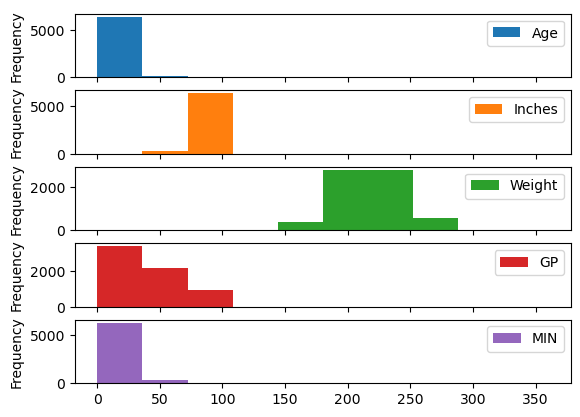

In [195]:
plt.figure()
df_stats[list(df_stats.columns)[:5]].plot(kind='hist', subplots=True)
plt.show()

## Feature Engineering

For feature engineering we create an additional feature which is the playstyle of a player. This is done with a clustering algorithms to group observations by playstyle. The features used for clustering are:

* `BOX_OUTS`
* `DEFLECTIONS`
* `REB`
* `DIST_MILES`
* `AVG_SPEED`
* `BLK`
* `PF`
* `PFD`

In [257]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, QuantileTransformer

playstyle_ft = ['BOX_OUTS','DEFLECTIONS','REB','DIST_MILES','AVG_SPEED','BLK','PF','PFD']

data_cluster = df_stats[playstyle_ft]

# standardize
scaler = StandardScaler()
scaler = scaler.fit(data_cluster)
data_cluster = pd.DataFrame(data=scaler.transform(data_cluster), columns=playstyle_ft)

clf = KMeans(3, init='random', random_state=42).fit(data_cluster)

df_stats_fe = df_stats.copy()
target = df_stats_fe.pop('target')
df_stats_fe['PLAYSTYLE']=clf.predict(data_cluster)
df_stats_fe['target'] = target

df_stats_fe_v2 = df_stats_fe.copy()
df_stats_fe_v2 = df_stats_fe_v2.drop(playstyle_ft, axis=1)

df_stats_qnt = df_stats.copy()

f = 1
qt = QuantileTransformer(n_quantiles=max(min(df_stats_qnt.shape[0] // 25, 1000), 10),output_distribution="normal",random_state=42)

df_stats_qnt[qt.get_feature_names_out()] = qt.fit_transform(df_stats_qnt.drop(['target'], axis=1))

<Figure size 640x480 with 0 Axes>

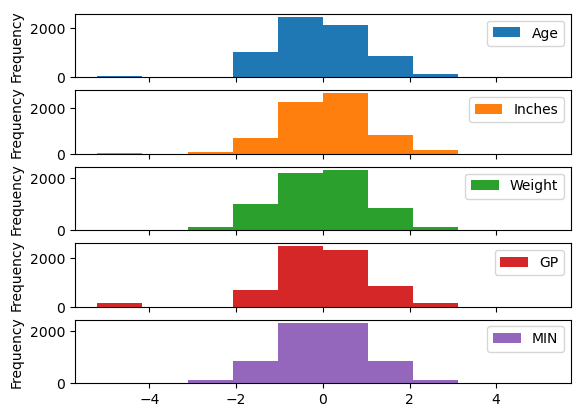

In [259]:
plt.figure()
df_stats_qnt[list(df_stats_qnt.columns)[:5]].plot(kind='hist', subplots=True)
plt.show()

# Experiments

In [381]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score as score

ss = {
    'n_estimators': [50,75,100],
    'max_depth': np.arange(2,5,1),
    'booster': ['gbtree','dart'],
    'learning_rate': [0.01,0.1,0.1],
    'objective': ["binary:hinge"]
}

def split(data, size):
    X = data.drop(columns=['target'],axis=1)
    y = data['target'].values

    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=size, random_state=42)

    return X_train, X_test, y_train, y_test

def train(X,y, params):
    
    model = xgboost.XGBClassifier()

    search = RandomizedSearchCV(model, params, n_iter=30, scoring='accuracy', random_state=42)

    res = search.fit(X,y)

    return res

## Experiment 1. Different Feature Engineering and Hyper parameterization

In [382]:
datasets = {
    'Raw': df_stats,
    'W/ FE': df_stats_fe,
    'W/ FE v2': df_stats_fe_v2,
    'W/ Qt': df_stats_qnt
}

scores = {}

for d in datasets:

    X_train, X_test, y_train, y_test = split(datasets.get(d),0.2)

    res = train(X_train, y_train, ss)

    scores[d] = {
        "best_params": res.best_params_,
        "val_best": res.best_score_,
        "val_best_std": res.cv_results_["std_test_score"][res.best_index_],
        "val": res.cv_results_['mean_test_score'],
    }

    pred = res.predict(X_test)

    scores[d]["test"] = score(y_test, pred)

    print(f'\nDataset: {d}\n---')
    print(f'  val: {np.round(scores[d]["val_best"],4)} +\- {np.round(scores[d]["val_best_std"],4)}')
    print(f'  test: {np.round(scores[d]["test"],4)}')



Dataset: Raw
---
  val: 0.6335 +\- 0.0063
  test: 0.6241

Dataset: W/ FE
---
  val: 0.6335 +\- 0.0063
  test: 0.6241

Dataset: W/ FE v2
---
  val: 0.6377 +\- 0.0091
  test: 0.6263

Dataset: W/ Qt
---
  val: 0.6335 +\- 0.0063
  test: 0.6241


In [383]:
best_params = scores['W/ FE v2']['best_params']

Text(0.5, 0, 'Iterations')

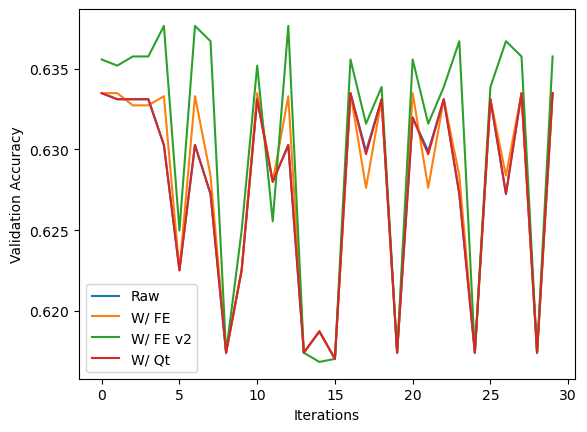

In [384]:
for d in scores:
    plt.plot(scores.get(d)["val"], label=f'{d}')

plt.legend()
plt.ylabel('Validation Accuracy')
plt.xlabel('Iterations')

## Experiment .2 - Understanding Features

In [387]:
best_params

{'objective': 'binary:hinge',
 'n_estimators': 100,
 'max_depth': 4,
 'learning_rate': 0.1,
 'booster': 'dart'}

[04:46:27] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "objetive" } are not used.



<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

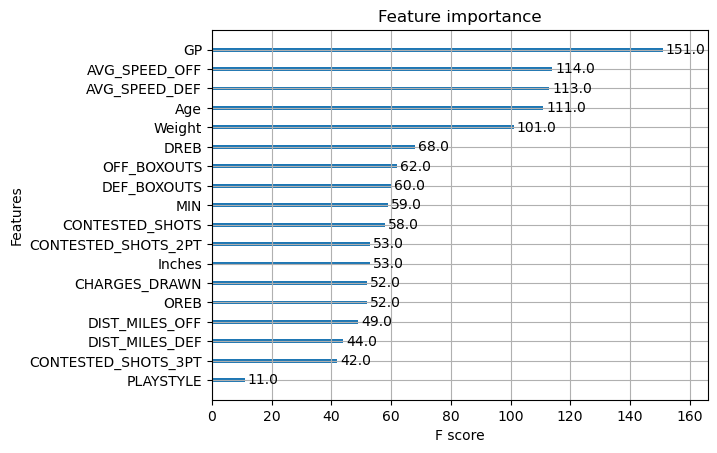

In [403]:
X_train, X_test, y_train, y_test = split(datasets.get('W/ FE v2'),0.2)

clf = xgboost.XGBClassifier(
    n_estimators = best_params['n_estimators'],
    max_depth = best_params['max_depth'],
    learning_rate = best_params['learning_rate'],
    booster = best_params['booster'],
    objetive = 'binary:hinge'
)

clf = clf.fit(X_train, y_train)
ft_imp = clf.feature_importances_
xgboost.plot_importance(clf)

In [391]:
ranking = np.argsort(np.abs(ft_imp))
res = [{} for i in range(len(ft_imp))]

for i in range(len(ft_imp)):
    n = len(ft_imp) - i
    idx = ranking[:n].copy()
    np.random.shuffle(idx)

    clf = xgboost.XGBClassifier(
        n_estimators = best_params['n_estimators'],
        max_depth = best_params['max_depth'],
        learning_rate = best_params['learning_rate'],
        booster = best_params['booster'],
        objective = 'binary:hinge',
        random_state=42
    )
    
    clf = clf.fit(X_train.iloc[:,idx], y_train)
    pred = clf.predict(X_test.iloc[:, idx])
    res[i] = {
        "acc": score(y_test, pred),
        "size": n/len(ft_imp)
    }

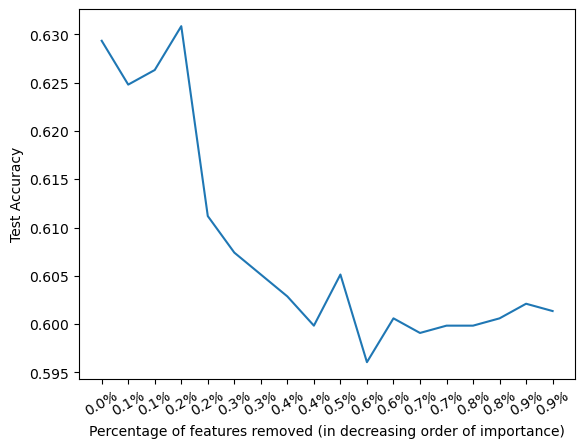

In [393]:
plt.plot(np.arange(0,len(res)),[r['acc'] for r in res])
plt.xticks(np.arange(len(res)),[f"{np.round(1-r['size'],1)}%" for r in res],rotation=30)
plt.ylabel('Test Accuracy')
plt.xlabel(f'Percentage of features removed (in decreasing order of importance)')
plt.show()

In [395]:
ranking = np.argsort(np.abs(ft_imp))[::-1]
res = [{} for i in range(len(ft_imp))]

for i in range(len(ft_imp)):
    n = len(ft_imp) - i
    idx = ranking[:n].copy()
    np.random.shuffle(idx)

    clf = xgboost.XGBClassifier(
        n_estimators = best_params['n_estimators'],
        max_depth = best_params['max_depth'],
        learning_rate = best_params['learning_rate'],
        booster = best_params['booster'],
        objective = 'binary:hinge',
        random_state=42
    )
    
    clf = clf.fit(X_train.iloc[:,idx], y_train)
    pred = clf.predict(X_test.iloc[:, idx])
    res[i] = {
        "acc": score(y_test, pred),
        "size": n/len(ft_imp),
        "features": idx
    }

In [396]:
best = res[np.argmax([r['acc'] for r in res])]
best

{'acc': 0.6316187594553706,
 'size': 0.2777777777777778,
 'features': array([ 4, 12,  3, 11, 14], dtype=int64)}

In [397]:
best_ft = list(df_stats_fe_v2.columns[best['features']])
best_ft

['MIN', 'CONTESTED_SHOTS_2PT', 'GP', 'CONTESTED_SHOTS', 'OFF_BOXOUTS']

In [398]:
clf = xgboost.XGBClassifier(
    n_estimators = best_params['n_estimators'],
    max_depth = best_params['max_depth'],
    learning_rate = best_params['learning_rate'],
    booster = best_params['booster'],
    objective='binary:hinge',
    random_state=42
)

clf = clf.fit(X_train[best_ft], y_train)
pred = clf.predict(X_test[best_ft])
score(y_test, pred)

0.6316187594553706

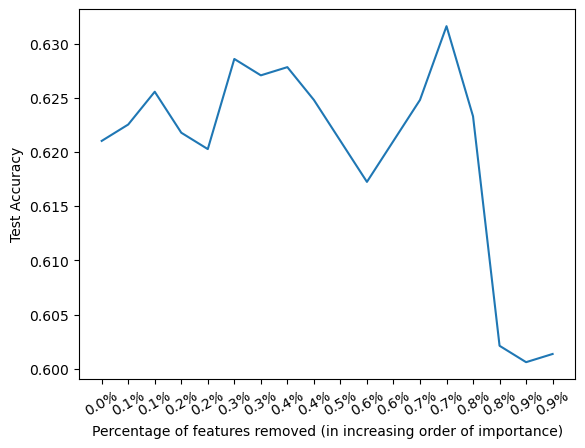

In [399]:
plt.plot(np.arange(0,len(res)),[r['acc'] for r in res])
plt.xticks(np.arange(len(res)),[f"{np.round(1-r['size'],1)}%" for r in res],rotation=30)
plt.ylabel('Test Accuracy')
plt.xlabel(f'Percentage of features removed (in increasing order of importance)')
plt.show()

## Explanations

In [373]:
shap.initjs()

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

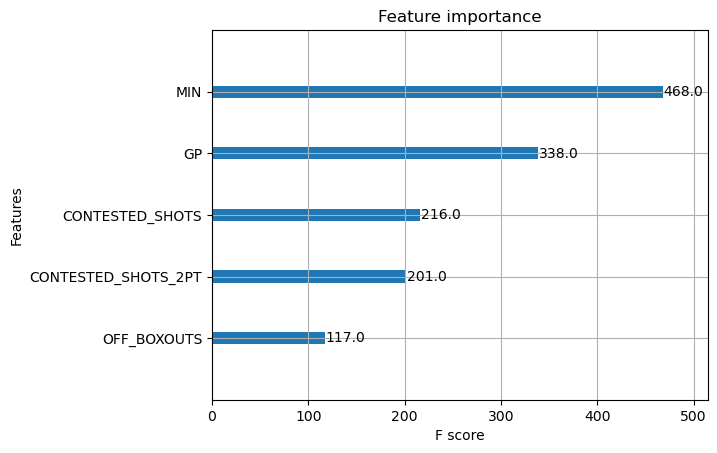

In [402]:
xgboost.plot_importance(clf)

In [407]:
explainer = shap.GradientExplainer(clf)
shap_values = explainer(X_test)
shap.plots.beeswarm(shap_values)

TypeError: __init__() missing 1 required positional argument: 'data'

In [ ]:
plt.figure(figsize=(6,6))
shap.plots.waterfall(shap_values[0])

print('a')